# Data Preparation
***
## Data Collection
***

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load RawData
rawData = pd.read_csv("../Data/Almond.csv")

***
## Data Exploration
***

In [3]:
total_rows = rawData.shape[0]
print(f"Total number of rows: {total_rows}")
missingL = rawData['Length (major axis)'].isnull().sum()
print(f"Percentage of missing Length: {(missingL/total_rows)*100} %")
missingW = rawData['Width (minor axis)'].isnull().sum()
print(f"Percentage of missing Width: {(missingW/total_rows)*100} %")
missingT = rawData['Thickness (depth)'].isnull().sum()
print(f"Percentage of missing Thickness: {(missingT/total_rows)*100} %")

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return rows that are outliers
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Example: Detect outliers for the 'Length' column
outliers_length = detect_outliers_iqr(rawData, 'Length (major axis)')
print(f"Outliers in 'Length':\n{outliers_length}")

# Check for duplicate rows
duplicates = rawData.duplicated()

num_duplicates = duplicates.sum()

print(f"Number of redundant rows: {num_duplicates}")
correlation_matrix = rawData[['Length (major axis)','Width (minor axis)','Thickness (depth)','Area']].corr()

print(f"Correlation Matrix: {correlation_matrix}")

Total number of rows: 2803
Percentage of missing Length: 30.574384587941488 %
Percentage of missing Width: 33.606849803781664 %
Percentage of missing Thickness: 35.81876560827685 %
Outliers in 'Length':
        Id  Length (major axis)  Width (minor axis)  Thickness (depth)  \
1019  1019           460.908081          236.788956                NaN   
1063  1063           469.993317          256.381378                NaN   
1064  1064           457.453674          253.380829                NaN   
1181  1181           512.625305          196.665649                NaN   
1182  1182           515.352478          198.328033                NaN   
1183  1183           499.412140          194.025864                NaN   
1184  1184           458.892334          185.880981                NaN   
1217  1217           466.678650                 NaN         111.687790   
1218  1218           477.257385                 NaN         107.354698   
1219  1219           464.381012                 NaN      

***
## Outliers
***

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

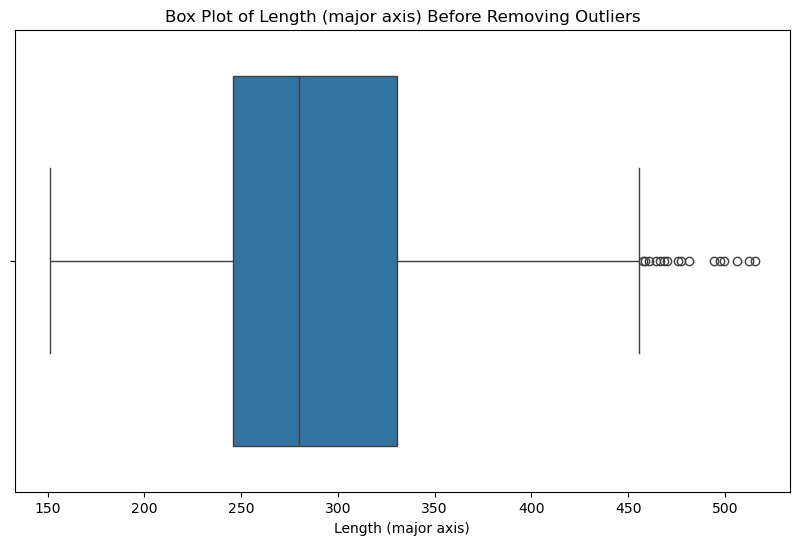

In [5]:
plt.figure(figsize=(10, 6))
plotdata = rawData.dropna(subset=['Length (major axis)'])
sns.boxplot(x=plotdata['Length (major axis)'])
plt.title('Box Plot of Length (major axis) Before Removing Outliers')
plt.show()

In [6]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask = ((df[column] >= lower_bound) & (df[column] <= upper_bound)) | df[column].isna()
    
    # Return the dataframe with outliers removed but NaN values preserved
    return df[mask]

In [7]:
numerical_columns = ['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)', 'Area', 'Perimeter', 'Roundness', 'Solidity', 'Compactness', 'Aspect Ratio', 'Eccentricity', 'Extent', 'Convex hull(convex area)']
rawData_no_outliers = rawData[['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)', 'Area', 'Perimeter', 'Roundness', 'Solidity', 'Compactness', 'Aspect Ratio', 'Eccentricity', 'Extent', 'Convex hull(convex area)', 'Type']].copy()
for column in numerical_columns:
    rawData_no_outliers = remove_outliers(rawData_no_outliers, column)

***
## Imputation
***

In [8]:
# Retrieve Length, Width and Thickness for imputation
# Aswell as Area
# rawData_no_outliers.reset_index(drop=True, inplace=True)
p_LWTA = rawData[['Length (major axis)','Width (minor axis)','Thickness (depth)','Area']].copy()
# Set Area to NaN where length is NaN
p_LWTA['Area'] = np.where(p_LWTA['Length (major axis)'].notna(),
                          p_LWTA['Area'],
                          np.nan)

In [9]:
# Import Sklearn libraries
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [10]:
# Use iterative imputation using sklearn
imputer = IterativeImputer(max_iter=10, random_state=0)
d_LWTA_imputed = pd.DataFrame(imputer.fit_transform(p_LWTA), columns=p_LWTA.columns)

In [11]:
# Calculate Roundness using the imputed Area when there is length
d_LWTA_imputed['Roundness'] = 4 * d_LWTA_imputed['Area'] / (np.pi * d_LWTA_imputed['Length (major axis)']**2)

In [12]:
# Remove irrelavent features
p_proc = rawData.drop(columns=['Id']).copy()
p_proc[['Length (major axis)','Width (minor axis)','Thickness (depth)','Roundness']] = d_LWTA_imputed[['Length (major axis)','Width (minor axis)','Thickness (depth)','Roundness']]
p_proc['Aspect Ratio'] = p_proc['Length (major axis)']/p_proc['Width (minor axis)']
p_proc['Eccentricity'] = (1 - (p_proc['Width (minor axis)']/p_proc['Length (major axis)'])**2) ** 0.5

***
## Handling Potential Bias
***

In [13]:
from imblearn.under_sampling import RandomUnderSampler

In [14]:
X = p_proc[['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)', 'Area', 'Perimeter', 'Roundness', 'Solidity', 'Compactness', 'Aspect Ratio', 'Eccentricity', 'Extent', 'Convex hull(convex area)']]
Y = p_proc['Type']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, Y)

X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='Type')

In [15]:
print(X_resampled.shape)
print(y_resampled.shape)

(2781, 12)
(2781,)


***
## Data Split
***

In [16]:
# Import libraries for NN
# Pretty sure this shit is just magic
import torch
from sklearn.preprocessing import LabelEncoder

In [17]:
X_resampled.reset_index(drop=True, inplace=True)
y_resampled.reset_index(drop=True, inplace=True)

In [18]:
# Label encoding (Not Really?)
label_encoder = LabelEncoder()

In [19]:
# X,Y -> X_tensor,Y_tensor
X_tensor = torch.tensor(X_resampled.values, dtype=torch.float32)
y_tensor = torch.tensor(label_encoder.fit_transform(y_resampled), dtype=torch.long)

In [20]:
# Splitting Dataset into training, validation, and testing sets
# Train + (Val | Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_tensor, 
    y_tensor, 
    test_size=0.3, 
    stratify=y_tensor, 
    random_state=21
)

# Val + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.5, 
    stratify=y_temp, 
    random_state=69
)

# Check the distribution of classes in each set
print("Training set class distribution:\n", pd.Series(y_train).value_counts(normalize=True))
print("Validation set class distribution:\n", pd.Series(y_val).value_counts(normalize=True))
print("Testing set class distribution:\n", pd.Series(y_test).value_counts(normalize=True))


Training set class distribution:
 0    0.333505
2    0.333505
1    0.332991
Name: proportion, dtype: float64
Validation set class distribution:
 1    0.333333
0    0.333333
2    0.333333
Name: proportion, dtype: float64
Testing set class distribution:
 1    0.334928
2    0.332536
0    0.332536
Name: proportion, dtype: float64


In [21]:
# Apply training data transformation across all three sets for consistency
mean = X_train.mean(dim=0)
std = X_train.std(dim=0)

X_train_norm = (X_train - mean)/std
X_val_norm = (X_val - mean)/std
X_test_norm = (X_test - mean)/std


Outputs:
- X_train_norm : y_train
- X_val_norm   : y_val
- X_test_norm  : y_test
- y_train
- y_val
- y_test
***

***
## Neural Network Definitions
***

In [22]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as Func
import torch.nn.init as init

In [ ]:
class FirstLayer(nn.Module):
    def __init__(self, output_size, activation='relu', init_method='he'):
        super(FirstLayer, self).__init__()
        self.fc = nn.Linear(12, output_size)
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")

        if init_method == 'he':
            init.kaiming_normal_(self.fc.weight, nonlinearity='relu')
        elif init_method == 'xavier':
            init.xavier_normal_(self.fc.weight)
        else:
            raise ValueError(f"Unsupported initialization method: {init_method}")

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x

In [ ]:
class OutputLayer(nn.Module):
    def __init__(self, input_size):
        super(OutputLayer, self).__init__()
        self.fc = nn.Linear(input_size, 3)

    def forward(self, x):
        x = self.fc(x)
        return x

In [ ]:
class ReluLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(ReluLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.activation = nn.ReLU()
        init.kaiming_normal_(self.fc.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x

In [ ]:
class LeakyReluLayer(nn.Module):
    def __init__(self, input_size, output_size, neg_slope=0.01):
        super(LeakyReluLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.activation = nn.LeakyReLU(negative_slope=neg_slope)
        init.kaiming_normal_(self.fc.weight, nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x

In [ ]:
class PReLULayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(PReLULayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.activation = nn.PReLU()
        init.kaiming_normal_(self.fc.weight, nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x

In [58]:
class SigmoidLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(SigmoidLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.activation = nn.Sigmoid()
        init.xavier_normal_(self.fc.weight)

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x

In [ ]:
class SwishLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(SwishLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.fc(x)
        return x * torch.sigmoid(x)

In [54]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.l1 = FirstLayer(output_size=64, activation='relu', init_method='he')
        self.l2 = ReluLayer(input_size=64, output_size=32)
        self.l3 = OutputLayer(input_size=32)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x

***
## Training Definitions
***

In [25]:
# Batching Function
def batch(X_ten, Y_ten, batch_size):
    num = X_ten.size(0)
    for n in range(0, num, batch_size):
        m = min(n + batch_size, num)
        yield X_ten[n:m], Y_ten[n:m]

In [26]:
# Training
def training(model, num_epochs, batch_size, X, y, learning_algo, obj_function):
    model.train()
    for epoch in range(num_epochs):
        for bX, bY in batch(X,y,batch_size):
            learning_algo.zero_grad()
            output = model(bX)
            loss = obj_function(output, bY)
            loss.backward()
            learning_algo.step()

***
## Evaluation/Testing Definition
***

In [61]:
def evaluate(model, X, y, obj_function):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        predicted_classes = torch.argmax(logits, dim=1)
        actual_classes = y
        num_classes = 3
        TP = [0] * num_classes
        TN = [0] * num_classes
        FP = [0] * num_classes
        FN = [0] * num_classes
    
        for i in range(num_classes):
            for j in range(len(actual_classes)):
                if predicted_classes[j] == i and actual_classes[j] == i:
                    TP[i] += 1
                elif predicted_classes[j] == i and actual_classes[j] != i:
                    FP[i] += 1
                elif predicted_classes[j] != i and actual_classes[j] == i:
                    FN[i] += 1
                else:
                    TN[i] += 1
        label_names = ['MAMRA','REGULAR','SANORA']
        for i in range(num_classes):
            print(f'Class {label_names[i]}:')
            print(f'TP: {TP[i]}, TN: {TN[i]}, FP: {FP[i]}, FN: {FN[i]}')
            accuracy = (TP[i] + TN[i]) / (TP[i] + TN[i] + FP[i] + FN[i]) * 100
            print(f'Accuracy for Class {label_names[i]}: {accuracy:.2f}%')
    
        correct_predictions = (predicted_classes == actual_classes).sum().item()
        total_samples = actual_classes.size(0)
        overall_accuracy = correct_predictions / total_samples * 100
        print(f'Overall Accuracy: {overall_accuracy:.2f}%')
        return accuracy

***
## Hyperparameters
***

In [28]:
# Hyperparameters
learning_rate  =0.005
num_epochs = 300
batch_size = 34

learning_opt = 0
# 0 - Admin
# 1 - Rprop
# 2 - SGD

objective_opt = 0
# 0 - CrossEntropyLoss
# 1 - BCEWithLogitsLoss

random_seed = 42

***
## Helpers
***

In [29]:
def learningAlgo(opt):
    if opt == 0:
        return optim.Adam
    elif opt == 1:
        return optim.Rprop
    else:
        return optim.SGD

In [35]:
def objectiveFunc(opt):
    if opt == 0:
        return nn.CrossEntropyLoss()
    elif opt == 1:
        return nn.BCEWithLogitsLoss()

In [31]:
def calculate_conf_matrix(predicted, y):
    conf_matrix = torch.zeros(3, 3, dtype=torch.int64)
    
    for t, p in zip(y.view(-1), predicted.view(-1)):
        conf_matrix[t.long(), p.long()] += 1
    
    return conf_matrix

In [32]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

***
## K-Fold Cross Validation
***

In [49]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [51]:
k = 5

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
fold_metrics = []

In [65]:
for fold, (train_index, val_index) in enumerate(skf.split(X_tensor, y_tensor)):
    print(f'Fold {fold + 1}/{k}')
    
    X_train, X_val = X_tensor[train_index], X_tensor[val_index]
    y_train, y_val = y_tensor[train_index], y_tensor[val_index]

    mean = X_train.mean(dim=0)
    std = X_train.std(dim=0)
    
    X_train_norm = (X_train - mean)/std
    X_val_norm = (X_val - mean)/std
    
    model = NeuralNetwork()
    optimizer = learningAlgo(learning_opt)(model.parameters(),lr=learning_rate)
    criterion = objectiveFunc(objective_opt)

    training(model, num_epochs, batch_size, X_train_norm, y_train, optimizer, criterion)
    # Training
    # for epoch in range(num_epochs):
    #     model.train()
    #     for bX, bY in batch(X_train_norm,y_train,batch_size):
    #         optimizer.zero_grad()
    #         outputs = model(bX)
    #         loss = criterion(outputs, bY)
            
    #         loss.backward()
    #         optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_norm)
        val_loss = criterion(val_outputs, y_val)
        _, predicted = torch.max(val_outputs.data, 1)
        accuracy = (predicted == y_val).sum().item() / y_val.size(0) * 100
        
        fold_metrics.append(accuracy)
        print(f'Validation Loss: {val_loss.item():.4f}, Accuracy: {accuracy:.2f}%')

# Overall Performance
print(f'K-Fold Cross-Validation Accuracy: {np.mean(fold_metrics):.2f}% ± {np.std(fold_metrics):.2f}%')

Fold 1/5
Validation Loss: 1.0447, Accuracy: 77.02%
Fold 2/5
Validation Loss: 1.1465, Accuracy: 79.68%
Fold 3/5
Validation Loss: 0.9601, Accuracy: 82.55%
Fold 4/5
Validation Loss: 0.9571, Accuracy: 76.98%
Fold 5/5
Validation Loss: 0.9217, Accuracy: 80.04%
K-Fold Cross-Validation Accuracy: 76.58% ± 2.98%


***
## Main
***

In [33]:
def run(num_epochs, batch_size, learning_rate, learning_opt, objective_opt, random_seed, X, Y):
    set_random_seed(random_seed)
    model = NeuralNetwork()
    learn_algo = learningAlgo(learning_opt)(model.parameters(),learning_rate)
    obj_func = objectiveFunc(objective_opt)
    training(model, num_epochs, batch_size, X, Y, learn_algo, obj_func)
    return evaluate(model, X_test_norm, y_test, obj_func)

In [62]:
run(300,34,0.005,0,0,42,X_train_norm,y_train)

Class MAMRA:
TP: 130, TN: 275, FP: 4, FN: 9
Accuracy for Class MAMRA: 96.89%
Class REGULAR:
TP: 112, TN: 271, FP: 7, FN: 28
Accuracy for Class REGULAR: 91.63%
Class SANORA:
TP: 134, TN: 248, FP: 31, FN: 5
Accuracy for Class SANORA: 91.39%
Overall Accuracy: 89.95%


91.38755980861244

***
## Grid Search
***

In [40]:
parameter_grid = {
    'learning_rate': [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.1, 0.5],
    'num_epochs': [10, 20, 30, 60, 125, 250, 500, 1000]
}
results = []

for learning_rate in parameter_grid['learning_rate']:
    for num_epochs in parameter_grid['num_epochs']:
        # Run the experiment
        result = run(num_epochs, batch_size, learning_rate, learning_opt, objective_opt, random_seed, X_train_norm, y_train)
        
        # Store the results in a dictionary
        results.append({
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'result': result  # Replace with actual metric (e.g., accuracy)
        })

print(results)

Class MAMRA:
TP: 140, TN: 0, FP: 281, FN: 0
Accuracy for Class MAMRA: 33.25%
Class REGULAR:
TP: 0, TN: 282, FP: 0, FN: 139
Accuracy for Class REGULAR: 66.98%
Class SANORA:
TP: 0, TN: 279, FP: 0, FN: 142
Accuracy for Class SANORA: 66.27%
Overall Accuracy: 33.25%
Class MAMRA:
TP: 140, TN: 0, FP: 281, FN: 0
Accuracy for Class MAMRA: 33.25%
Class REGULAR:
TP: 0, TN: 282, FP: 0, FN: 139
Accuracy for Class REGULAR: 66.98%
Class SANORA:
TP: 0, TN: 279, FP: 0, FN: 142
Accuracy for Class SANORA: 66.27%
Overall Accuracy: 33.25%
Class MAMRA:
TP: 140, TN: 0, FP: 281, FN: 0
Accuracy for Class MAMRA: 33.25%
Class REGULAR:
TP: 0, TN: 282, FP: 0, FN: 139
Accuracy for Class REGULAR: 66.98%
Class SANORA:
TP: 0, TN: 279, FP: 0, FN: 142
Accuracy for Class SANORA: 66.27%
Overall Accuracy: 33.25%
Class MAMRA:
TP: 140, TN: 0, FP: 281, FN: 0
Accuracy for Class MAMRA: 33.25%
Class REGULAR:
TP: 0, TN: 282, FP: 0, FN: 139
Accuracy for Class REGULAR: 66.98%
Class SANORA:
TP: 0, TN: 279, FP: 0, FN: 142
Accuracy fo

KeyboardInterrupt: 

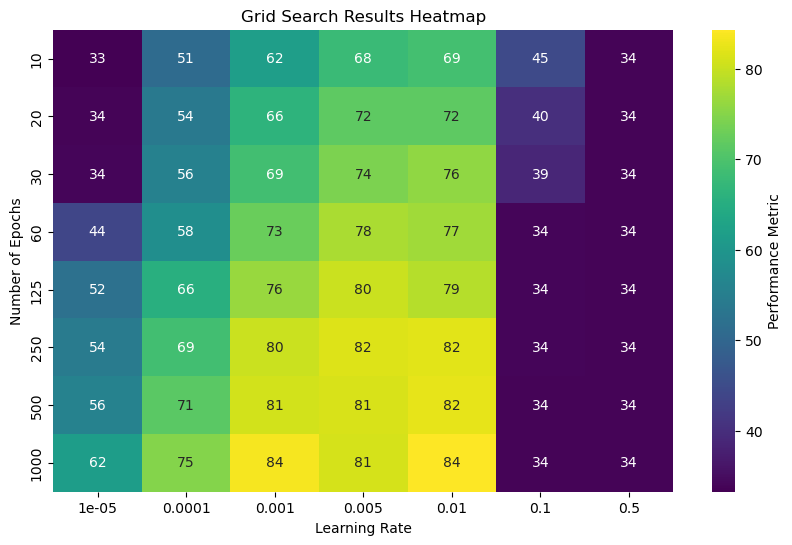

In [28]:
# Create a DataFrame from your results
results_df = pd.DataFrame(results)

# Pivot the DataFrame to create a matrix for the heatmap
heatmap_data = results_df.pivot(index='num_epochs', columns='learning_rate', values='result')

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', cbar_kws={'label': 'Performance Metric'})
plt.title('Grid Search Results Heatmap')
plt.xlabel('Learning Rate')
plt.ylabel('Number of Epochs')
plt.show()

***